# HubSpot CRM Analysis: Fast Insights with DuckDB
This notebook demonstrates data cleaning, enrichment, and visualization on a synthetic CRM dataset using DuckDB.

In [1]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create DuckDB connection
conn = duckdb.connect(database=':memory:')

In [3]:
# Load CSV files and import into DuckDB
conn.execute("CREATE TABLE contacts AS SELECT * FROM read_csv_auto('contacts.csv')")
conn.execute("CREATE TABLE deals AS SELECT * FROM read_csv_auto('deals.csv')")

## Data Cleaning
Let's fix missing or corrupted values.

In [4]:
# Fill missing 'industry' values with 'Unknown'
conn.execute("UPDATE contacts SET industry = 'Unknown' WHERE industry IS NULL")
# Set empty 'amount' values to 0
conn.execute("UPDATE deals SET amount = 0 WHERE amount IS NULL")

## Enrichment: Company Segmentation
Add a segment based on company size.

In [5]:
# Segmentation query
segment_query = '''
SELECT *,
  CASE 
    WHEN company_size <= 10 THEN 'Small'
    WHEN company_size <= 50 THEN 'Medium'
    ELSE 'Enterprise'
  END AS size_segment
FROM contacts
'''
segmented_contacts = conn.execute(segment_query).df()
segmented_contacts.head()

,contact_id,email,industry,created_at,owner,company_size,country,size_segment
0,C0000,user0@company.com,Healthcare,2024-01-12,Diana,195,UK,Enterprise
1,C0001,user1@company.com,Unknown,2024-08-20,Diana,257,Germany,Enterprise
2,C0002,user2@company.com,Education,2024-04-24,Charlie,473,UK,Enterprise
3,C0003,user3@company.com,Finance,2024-07-04,Alice,420,France,Enterprise
4,C0004,user4@company.com,Technology,2024-11-27,Diana,475,Spain,Enterprise


## Visualization: Top Revenue-Generating Industries

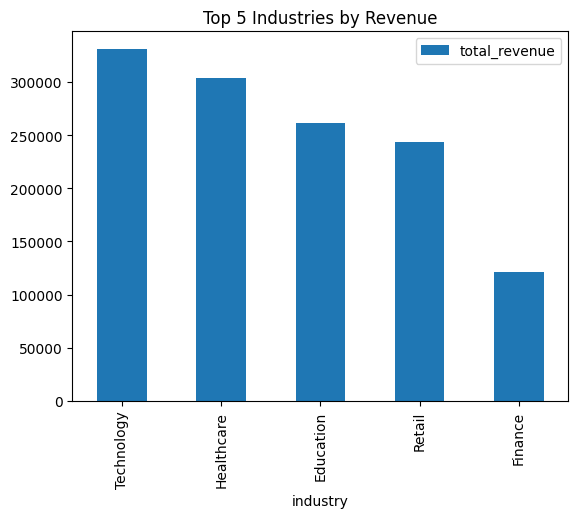

In [6]:
query = """
SELECT industry, SUM(amount) AS total_revenue
FROM contacts
JOIN deals USING (contact_id)
GROUP BY industry
ORDER BY total_revenue DESC
LIMIT 5
"""
df = conn.execute(query).df()
df.plot(kind='bar', x='industry', y='total_revenue', title='Top 5 Industries by Revenue')
plt.show()

## Deal Closures Over Time

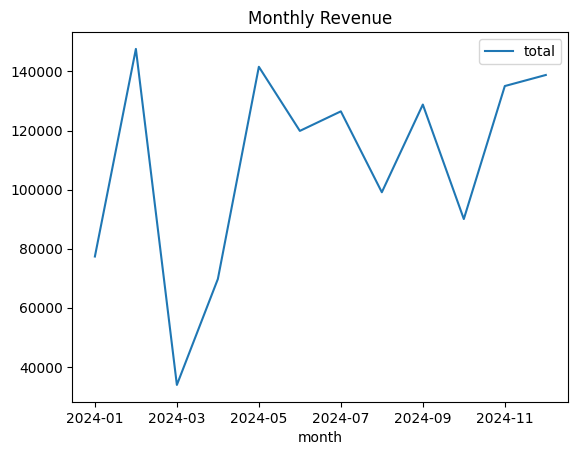

In [7]:
query = """
SELECT strftime(close_date, '%Y-%m') AS month, SUM(amount) as total
FROM deals
GROUP BY month
ORDER BY month
"""
df = conn.execute(query).df()
df.plot(x='month', y='total', kind='line', title='Monthly Revenue')
plt.show()

## Natural Language Style Insight

**Question:** Which sales rep closed the most revenue from enterprise companies in Q1 2025?

**SQL:**

In [12]:
conn.execute("""
SELECT owner, SUM(amount) AS total_revenue
FROM deals 
JOIN enriched_contacts USING (contact_id)
WHERE size_segment = 'Enterprise'
GROUP BY owner
ORDER BY total_revenue DESC
""").df()

,owner,total_revenue
0,Diana,455483.0
1,Alice,323488.0
2,Bob,250386.0
3,Charlie,172062.0
